# Assignment 1: Algorithm Selection -- Practical Machine Learning

A running set of experiments and data analysis completed in accordance with the assignment description. I chose to use the [`Wine Quality` dataset](https://archive-beta.ics.uci.edu/dataset/186/wine+quality).

Imports for this project will be introduced as they are needed for clarity and usability.

For much of the data analysis, I model my process after Chapter 2 of "[Hands On Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)" By Aurelien Geron, my go to reference for basic ML operations.

In [1]:
import sys
from pathlib import Path

IMAGES_PATH = Path() / "images"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import pandas as pd
red_wine_data = pd.read_csv("data/winequality-red.csv", sep=';') # Examining the raw `.txt` file, separate on the ';' char
red_wine_data.head() # View the first five elements to ensure the data was loaded correctly

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
red_wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [28]:
temp = red_wine_data.describe()
print(temp.style.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
 & fixed acidity & volatile acidity & citric acid & residual sugar & chlorides & free sulfur dioxide & total sulfur dioxide & density & pH & sulphates & alcohol & quality \\
count & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 & 1599.000000 \\
mean & 8.319637 & 0.527821 & 0.270976 & 2.538806 & 0.087467 & 15.874922 & 46.467792 & 0.996747 & 3.311113 & 0.658149 & 10.422983 & 5.636023 \\
std & 1.741096 & 0.179060 & 0.194801 & 1.409928 & 0.047065 & 10.460157 & 32.895324 & 0.001887 & 0.154386 & 0.169507 & 1.065668 & 0.807569 \\
min & 4.600000 & 0.120000 & 0.000000 & 0.900000 & 0.012000 & 1.000000 & 6.000000 & 0.990070 & 2.740000 & 0.330000 & 8.400000 & 3.000000 \\
25% & 7.100000 & 0.390000 & 0.090000 & 1.900000 & 0.070000 & 7.000000 & 22.000000 & 0.995600 & 3.210000 & 0.550000 & 9.500000 & 5.000000 \\
50% & 7.900000 & 0.520000 & 0.260000 & 2.200000 & 0.079

In [48]:
red_wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [5]:
red_wine_data["alcohol"].value_counts()

9.500000     139
9.400000     103
9.800000      78
9.200000      72
10.000000     67
            ... 
9.950000       1
9.233333       1
9.250000       1
9.050000       1
10.750000      1
Name: alcohol, Length: 65, dtype: int64

In [6]:
red_wine_data["alcohol"].quantile(0.97)


12.8

In [7]:
red_corr_matrix = red_wine_data.corr()
red_corr_matrix["alcohol"].sort_values(ascending=False)

alcohol                 1.000000
quality                 0.476166
pH                      0.205633
citric acid             0.109903
sulphates               0.093595
residual sugar          0.042075
fixed acidity          -0.061668
free sulfur dioxide    -0.069408
volatile acidity       -0.202288
total sulfur dioxide   -0.205654
chlorides              -0.221141
density                -0.496180
Name: alcohol, dtype: float64

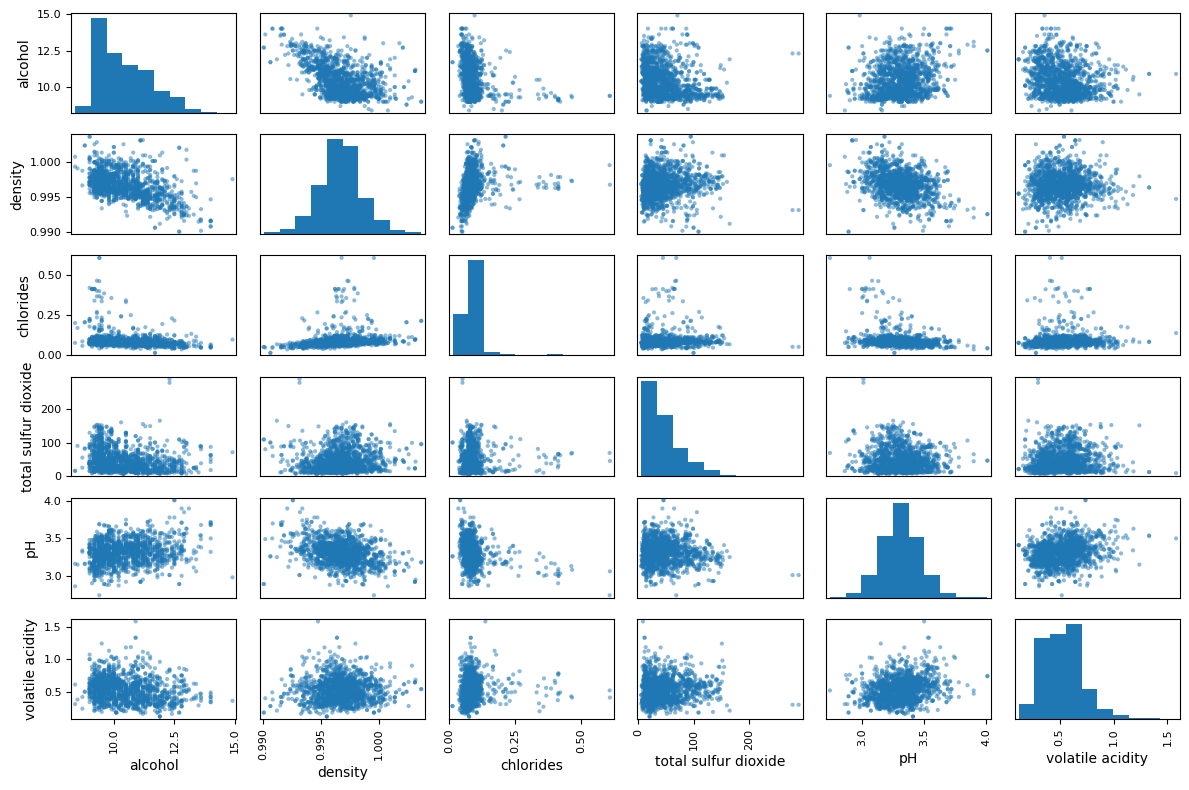

In [8]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

attributes = ["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]
scatter_matrix(red_wine_data[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plots")

#### Visualization

To better understand the data given, I chose to examine things visually. I also pulled in the convenient figure saving function provided by [this notebook.](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb)

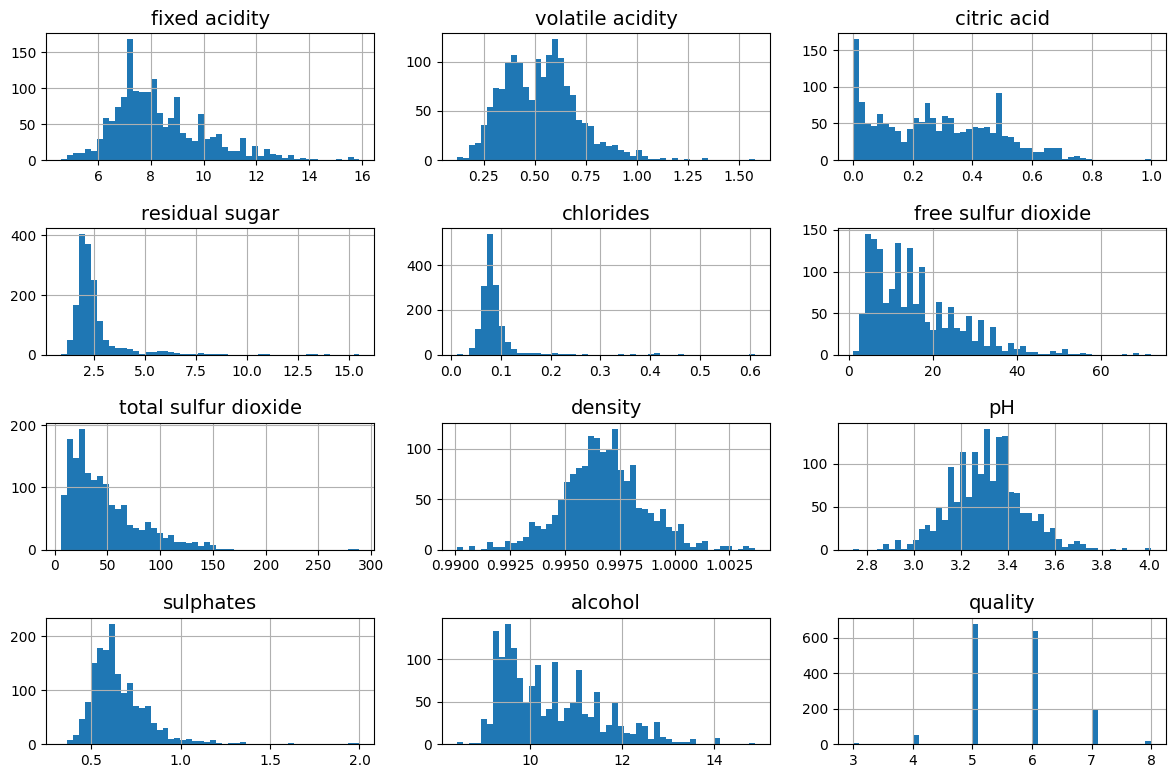

In [9]:
import matplotlib.pyplot as plt
import sys

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

red_wine_data.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")  # extra code
plt.show()

#### Data Selection

I've based my feature selection process off of examining the statistical correlation between alcohol and the other parameters. This choice was made due to the general consensuses that aged wine is better, which consequently leads to a higher alcohol content. I also chose to keep a simple majority of the features, settling on the six that correlated highest with alcohol.

A secondary analysis will be conducted with an automated feature selection algorithm, [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). This secondary analysis is intended to provide an additional layer to the model selection process. The RFE process will select the top six features for a given model and not necessarily the same parameters as those I selected.

The decision was also made to drop some entries. To avoid extended outlier detection analysis, I chose to exclude any wine that was given a quality below 5 and above a 7. This was done to help reduce the variance in the dataset, allowing for a better baseline training accuracy.

In [10]:
red_wine_data_copy = red_wine_data

red_wine_no_outliers = red_wine_data_copy[(red_wine_data_copy["quality"] > 4) &  (red_wine_data_copy["quality"] < 8)]

red_feat = red_wine_no_outliers[["alcohol", "density", "chlorides", "total sulfur dioxide", "pH", "volatile acidity"]].copy()
red_qual = red_wine_no_outliers[["quality"]].copy()

In [11]:
red_wine_no_outliers.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Model Selection

Six models were explored for the model selection portion of this project. Each model is ran using the default hyperparameters with no hyperparameter optimization. To make a comparison between models, standard accuracy is used as the metric. Each model is also assessed using a 10-folds cross-validator.

In [34]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import numpy as np
from tabulate import tabulate

models = [RandomForestClassifier(), SVC(), LogisticRegression(), tree.DecisionTreeClassifier(), tree.DecisionTreeRegressor(), GradientBoostingClassifier() ]

single_run_mean_acc = []
single_run_std = []
single_run_acc_var = []

for model in models:
    pipeline = make_pipeline(StandardScaler(), model)

    scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")

    #print(f'{model} accuracy scores for Random Forest: %s' % scores)
    single_run_mean_acc.append(np.mean(scores))
    single_run_std.append(np.std(scores))

    model_var = (np.mean(scores),np.std(scores))
    #print(f'{model} accuracy for Random Forest: %.3f +/- %.3f' % model_var)
    variance = '%.3f +/- %.3f' % model_var
    single_run_acc_var.append(variance)

table = [['Random Forest', 'SVC', 'Log Reg', 'D. Tree Classifier', 'D. Tree Reg', 'Gradient Boost'], single_run_mean_acc, single_run_acc_var]
print(tabulate(table))


------------------  ------------------  ------------------  ------------------  -------------------  ------------------
Random Forest       SVC                 Log Reg             D. Tree Classifier  D. Tree Reg          Gradient Boost
0.5665693621470896  0.5948849773440223  0.6139987800627396  0.5033025444405717  0.49996514464970376  0.5843238062042523
0.567 +/- 0.024     0.595 +/- 0.063     0.614 +/- 0.061     0.503 +/- 0.044     0.500 +/- 0.052      0.584 +/- 0.033
------------------  ------------------  ------------------  ------------------  -------------------  ------------------


Text(50.7222222222222, 0.5, 'Algorithm')

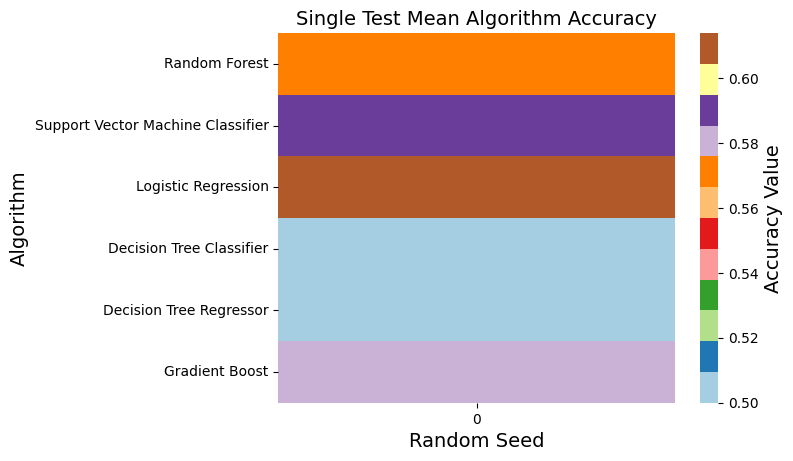

In [41]:
import seaborn as sns

data = pd.DataFrame(single_run_mean_acc).T
data.columns = ['Random Forest', 'Support Vector Machine Classifier', 'Logistic Regression', 'Decision Tree Classifier', 'Decision Tree Regressor', 'Gradient Boost']

ax = sns.heatmap(data.T,cbar_kws={"label":"Accuracy Value"}, cmap=sns.color_palette("Paired"))
plt.title("Single Test Mean Algorithm Accuracy")
plt.xlabel("Random Seed")
plt.ylabel("Algorithm")

Text(50.7222222222222, 0.5, 'Algorithm')

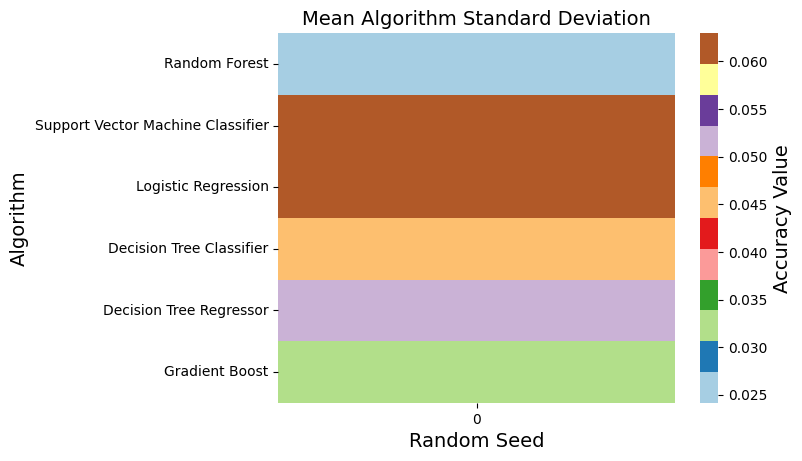

In [42]:
data = pd.DataFrame(single_run_std).T
data.columns = ['Random Forest', 'Support Vector Machine Classifier', 'Logistic Regression', 'Decision Tree Classifier', 'Decision Tree Regressor', 'Gradient Boost']

ax = sns.heatmap(data.T,cbar_kws={"label":"Accuracy Value"}, cmap=sns.color_palette("Paired"))
plt.title("Mean Algorithm Standard Deviation")
plt.xlabel("Random Seed")
plt.ylabel("Algorithm")

In [43]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
import numpy as np
from tabulate import tabulate

def random_model_state(state=0):
    models = [RandomForestClassifier(random_state=state), SVC(random_state=state),\
        LogisticRegression(random_state=state), tree.DecisionTreeClassifier(random_state=state),\
        tree.DecisionTreeRegressor(random_state=state), GradientBoostingClassifier(random_state=state) ]
    
    return models

mean_acc = []
mean_std = []

for i in range(0, 30):
    models = random_model_state(i)

    temp_acc = []
    temp_acc_var = []  

    for model in models:
        

        pipeline = make_pipeline(StandardScaler(), model)

        scores = cross_val_score(pipeline, X=red_feat, y=np.ravel(red_qual), cv=10, n_jobs=1, scoring="accuracy")

        temp_acc.append(np.mean(scores))

        temp_acc_var.append(np.std(scores))

    #print(f'{model} accuracy scores for Random Forest: %s' % scores)
    mean_acc.append(temp_acc)
    mean_std.append(temp_acc_var)
    #print(f'{model} accuracy for Random Forest: %.3f +/- %.3f' % model_var)

full_mean_acc =[]
full_mean_std = []

full_mean_acc = np.mean(mean_acc, axis=0)
full_mean_std = np.mean(acc_var, axis=0)
model_var = (full_mean_acc, full_mean_std)

# Table output modeled after [this](https://learnpython.com/blog/print-table-in-python/) blog post.

table = [['Random Forest', 'SVC', 'Log Reg', 'D. Tree Classifier', 'D. Tree Reg', 'Gradient Boost'], full_mean_acc, full_var_acc]
print(tabulate(table))

-------------------  -------------------  --------------------  -------------------  -------------------  --------------------
Random Forest        SVC                  Log Reg               D. Tree Classifier   D. Tree Reg          Gradient Boost
0.5660903915417684   0.5948849773440227   0.6139987800627399    0.5111126118275822   0.5016679737423029   0.5852667886603926
0.03543457244882099  0.06298003734987917  0.061054170814725646  0.04360171535254336  0.05500459413063082  0.034097594344482576
-------------------  -------------------  --------------------  -------------------  -------------------  --------------------


Text(50.7222222222222, 0.5, 'Algorithm')

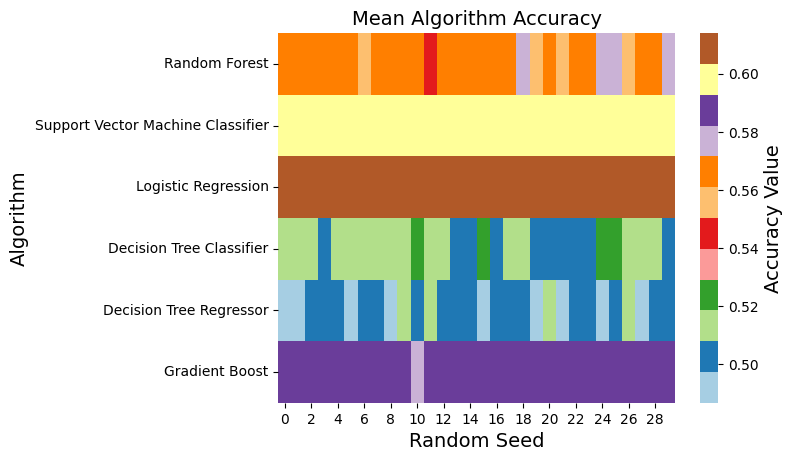

In [44]:
import seaborn as sns

data = pd.DataFrame(mean_acc)
data.columns = ['Random Forest', 'Support Vector Machine Classifier', 'Logistic Regression', 'Decision Tree Classifier', 'Decision Tree Regressor', 'Gradient Boost']

ax = sns.heatmap(data.T,cbar_kws={"label":"Accuracy Value"}, cmap=sns.color_palette("Paired"))
plt.title("Mean Algorithm Accuracy")
plt.xlabel("Random Seed")
plt.ylabel("Algorithm")

Text(50.7222222222222, 0.5, 'Algorithm')

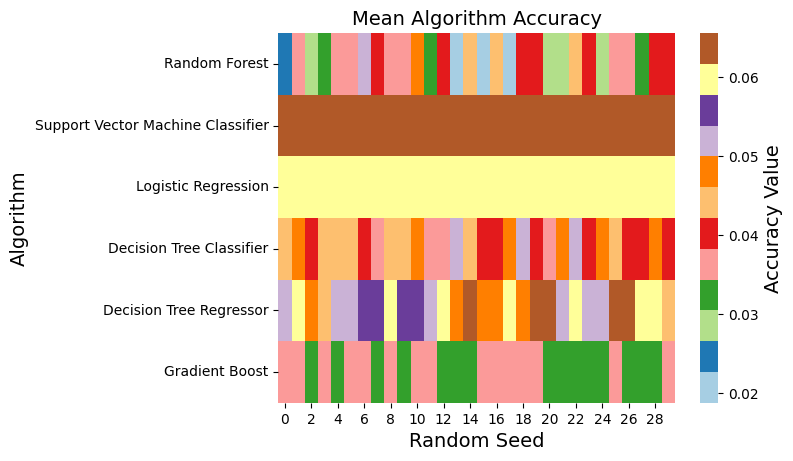

In [46]:
data = pd.DataFrame(acc_var)
data.columns = ['Random Forest', 'Support Vector Machine Classifier', 'Logistic Regression', 'Decision Tree Classifier', 'Decision Tree Regressor', 'Gradient Boost']

ax = sns.heatmap(data.T,cbar_kws={"label":"Accuracy Value"}, cmap=sns.color_palette("Paired"))
plt.title("Mean Algorithm Standard Deviation")
plt.xlabel("Random Seed")
plt.ylabel("Algorithm")

In [ ]:
x = red_wine_no_outliers.drop(["quality"], axis=1)
X = x.copy()
y = red_qual

def features(classifier):
    
    rfe = RFE(estimator=classifier, n_features_to_select=7)
    # selected = rfe.fit(X, np.ravel(y)).transform(X)
    selected = rfe.fit(X, np.ravel(y))
    out = selected.support_.tolist()
    #out = out.as_type(bool)
    print(out)
    features = []

    for i in range(len(out)):
        
        if out[i] == False:
            print(i)
            X.drop(red_wine_data.columns.values[i], axis=1, inplace=True)
    print(features)
    

features(tree.DecisionTreeRegressor())

X.head()



# model_tree = RandomForestClassifier(random_state=0)
# x_train, x_test, y_train, y_test = features(model_tree)
# pred = model_tree.fit(x_train,np.ravel(y_train)).predict(x_test)
# #print('tree accuracy: ', accuracy(pred, y_test))

## Post Model Selection

After getting base-line accuracy for each of the models, I decided to further investigate my choice of features. The entire motivation of this additional exploration was to ensure that my final choice of "best algorithm" wasn't motivated by poor feature selection. Through application of recursive feature elimination with six features being selected, I found that `density`, `sulphates`, and `pH` were consistently the features that contributed the least, with `density` and `sulphates` being selected consistently over `pH` as the sixth feature. This feature selection was not ran on the SVC model, despite it being a supervised learning model with a `fit` method, the requirements for RFE, I couldn't seem to find a way to get things to run. However, the conclusion reached above is true for 5/6 of the models used in this assessment.